# Introduction

TODO: add here introductary description of the project

# Imports and Data

In [1]:

import pandas as pd
import numpy as np
from config import DATASET_NAME
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from utils.plotting import plot_hist,plot_bar,plot_pie,plot_bar2
from utils.evaluation import train_binary_classifier,make_logreg_pipeline
from utils.chategorize import categorize_bp

In [3]:
DATASET_NAME.parent / "train.csv"

PosixPath('/Users/lizarabkina/PythonProjects/Cardio/data/train.csv')

In [4]:
df = pd.read_csv(DATASET_NAME, sep=";")

In [5]:
original_df = df.copy()
original_df.shape

(70000, 13)

In [6]:
df = original_df.copy() # working df


# Data Cleaning


In [7]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [8]:
df.shape,df.columns


((70000, 13),
 Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
        'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
       dtype='object'))

Columns - Features:
- age - in days (convert to years)
- gender - 1/2 (female/male)
- height - in cm
- weight - in kg
- ap_hi,ap_lo - systolic/diastolic blood pressure
- cholesterol,glucose - levels (normal, 2: above normal, 3: well above normal )
- smoke,alco,active - binary lifestyle features
- cardio - target (1 = disease,0 = no disease)


In [9]:
print("Missing values:\n",df.isnull().sum())

Missing values:
 id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


- We have no Null values

We remove id because it doesn't have any meaning.

In [10]:
df = df.drop(columns=['id'])

In [11]:
print(f"Dataset contains {df.duplicated().sum()} duplicates.")

Dataset contains 24 duplicates.


In [12]:
duplicated = df[df.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['gender', 'height', 'weight'], ascending= False)
duplicated.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
10494,16937,2,170,70.0,120,80,1,1,0,0,0,0
44653,16937,2,170,70.0,120,80,1,1,0,0,0,0
1142,17493,2,169,74.0,120,80,1,1,0,0,1,1
50432,17493,2,169,74.0,120,80,1,1,0,0,1,1
32683,17535,2,165,65.0,120,80,1,1,0,0,1,0


In [13]:
df.drop_duplicates(keep="first", inplace =True)
print(f"After removal of duplicates total of {df.shape[0]} rows and {df.shape[1]} columns remained.")

After removal of duplicates total of 69976 rows and 12 columns remained.


# EDA

## Quick Data Checks

- Check data types

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69976 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69976 non-null  int64  
 1   gender       69976 non-null  int64  
 2   height       69976 non-null  int64  
 3   weight       69976 non-null  float64
 4   ap_hi        69976 non-null  int64  
 5   ap_lo        69976 non-null  int64  
 6   cholesterol  69976 non-null  int64  
 7   gluc         69976 non-null  int64  
 8   smoke        69976 non-null  int64  
 9   alco         69976 non-null  int64  
 10  active       69976 non-null  int64  
 11  cardio       69976 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


- Check missing data and duplicates

- Basic statistics

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,69976.0,19468.950126,2467.374620,10798.0,17664.0,19703.0,21327.0,23713.0
gender,69976.0,1.349648,0.476862,1.0,1.0,1.0,2.0,2.0
height,69976.0,164.359152,8.211218,55.0,159.0,165.0,170.0,250.0
weight,69976.0,74.208519,14.397211,10.0,65.0,72.0,82.0,200.0
ap_hi,69976.0,128.820453,154.037729,-150.0,120.0,120.0,140.0,16020.0
ap_lo,69976.0,96.636261,188.504581,-70.0,80.0,80.0,90.0,11000.0
cholesterol,69976.0,1.366997,0.680333,1.0,1.0,1.0,2.0,3.0
gluc,69976.0,1.226535,0.572353,1.0,1.0,1.0,1.0,3.0
smoke,69976.0,0.088159,0.283528,0.0,0.0,0.0,0.0,1.0
alco,69976.0,0.053790,0.225604,0.0,0.0,0.0,0.0,1.0


- Target balance

In [16]:
print("Target groups (absolute values):",df["cardio"].value_counts())
print("_______________________________")
print("Target groups (%):",df["cardio"].value_counts(normalize=True).mul(100).round(2).astype(str) + "%")

Target groups (absolute values): cardio
0    35004
1    34972
Name: count, dtype: int64
_______________________________
Target groups (%): cardio
0    50.02%
1    49.98%
Name: proportion, dtype: object


Observation: Positive class (cardio disease) = 49.7% -> mild imbalance.

- Convert age to years and create BMI

In [17]:
df["age_years"]= (df["age"] / 365).round().astype(int)
df["bmi"] = (df["weight"] / (df["height"]/100)**2).round(1)

In [18]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,22.0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.9
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.5
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.7
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.0


In [19]:
num_cols = df.select_dtypes(include=np.number).columns
for col in num_cols:
    print(f"\n{col}")
    print(f"Min: {df[col].min()},  Max: {df[col].max()},  Unique: {df[col].nunique()}")



age
Min: 10798,  Max: 23713,  Unique: 8076

gender
Min: 1,  Max: 2,  Unique: 2

height
Min: 55,  Max: 250,  Unique: 109

weight
Min: 10.0,  Max: 200.0,  Unique: 287

ap_hi
Min: -150,  Max: 16020,  Unique: 153

ap_lo
Min: -70,  Max: 11000,  Unique: 157

cholesterol
Min: 1,  Max: 3,  Unique: 3

gluc
Min: 1,  Max: 3,  Unique: 3

smoke
Min: 0,  Max: 1,  Unique: 2

alco
Min: 0,  Max: 1,  Unique: 2

active
Min: 0,  Max: 1,  Unique: 2

cardio
Min: 0,  Max: 1,  Unique: 2

age_years
Min: 30,  Max: 65,  Unique: 28

bmi
Min: 3.5,  Max: 298.7,  Unique: 494


In [20]:
# import math
# import matplotlib.pyplot as plt

# # choose your dataframe & feature list
# X = df  # or df
# features = ["age_years","height","weight","bmi","ap_hi","ap_lo"]  # edit as you like

# n = len(features)
# cols = 3                                  # how many plots per row
# rows = math.ceil(n / cols)

# fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), squeeze=False)

# for i, col in enumerate(features):
#     ax = axes[i // cols, i % cols]
#     X[col].dropna().hist(bins=30, ax=ax)
#     ax.set_title(col)
#     ax.set_xlabel(col)
#     ax.set_ylabel("Count")

# # hide any empty subplots
# for j in range(n, rows*cols):
#     fig.delaxes(axes[j // cols, j % cols])

# fig.suptitle("Feature Distributions", y=1.02, fontsize=14)
# fig.tight_layout()
# plt.show()


In [21]:
# rules = (
#     (df["age_years"].between(18, 90)) &
#     (df["height"].between(120, 220)) &
#     (df["weight"].between(30, 250)) &
#     (df["ap_hi"].between(70, 250)) &
#     (df["ap_lo"].between(40, 150)) &
#     (df["ap_hi"] >= df["ap_lo"])
# )
# clean = df[rules].copy()
# print("Kept:", clean.shape, "Removed:", df.shape[0]-clean.shape[0])

In [22]:
# import numpy as np

# def count_outliers_iqr(df, cols=None, k=1.5):
#     """
#     Count outliers per column using IQR method.
    
#     Parameters:
#         df : DataFrame
#         cols : list of columns to check (default: all numeric)
#         k : multiplier for IQR (default 1.5)
#     """
#     if cols is None:
#         cols = df.select_dtypes(include=np.number).columns

#     for col in cols:
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower, upper = Q1 - k*IQR, Q3 + k*IQR
#         n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
#         print(f"{col:<10}: {n_outliers} outliers")


In [23]:
# outline_free_df = df.copy()
# outline_free_df[['height', 'weight']] = np.log(outline_free_df[['height', 'weight']])
# outliers(outline_free_df[['height', 'weight']])


In [24]:
# import numpy as np
# import matplotlib.pyplot as plt

# # pick the columns you want to visualize
# cols = ["height", "weight"]

# fig, axes = plt.subplots(len(cols), 2, figsize=(10, 4*len(cols)))

# for i, col in enumerate(cols):
#     # original
#     axes[i, 0].hist(df[col], bins=30, color="skyblue", edgecolor="black")
#     axes[i, 0].set_title(f"{col} — original scale")
#     axes[i, 0].set_xlabel(col)
#     axes[i, 0].set_ylabel("Count")

#     # log-transformed
#     axes[i, 1].hist(np.log(df[col]), bins=30, color="lightcoral", edgecolor="black")
#     axes[i, 1].set_title(f"{col} — log-transformed")
#     axes[i, 1].set_xlabel(f"log({col})")
#     axes[i, 1].set_ylabel("Count")

# plt.tight_layout()
# plt.show()


#### Weight& BMI cut off

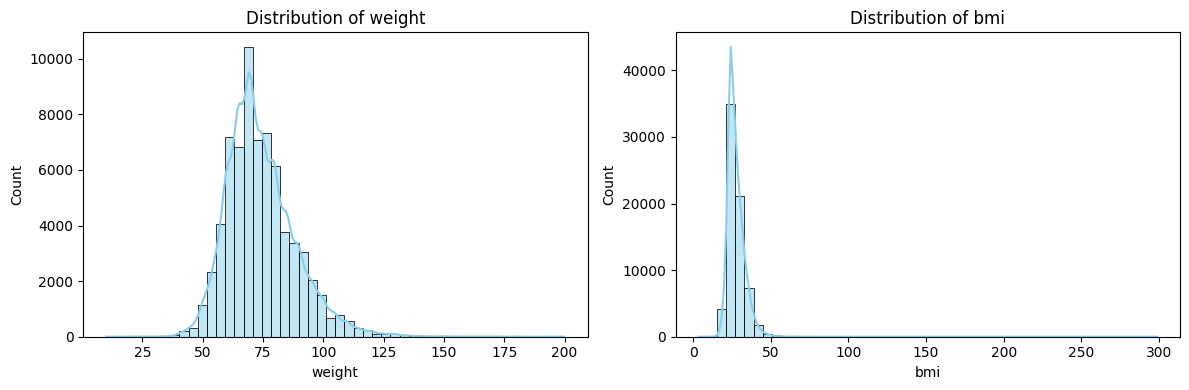

In [25]:
plot_hist(df,["weight","bmi"])

In [26]:
pd.set_option('display.max_rows', None)
df[df["bmi"]<12].sort_values(by = "bmi",ascending=False).head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
18559,18140,1,160,30.0,120,80,1,1,0,0,1,1,50,11.7
16906,17272,2,170,31.0,150,90,2,2,0,0,1,1,47,10.7
60699,18875,1,171,29.0,110,70,2,1,0,0,1,1,52,9.9
26806,23284,1,157,23.0,110,80,1,1,0,0,1,0,64,9.3
60188,21855,1,162,21.0,120,80,2,1,0,0,1,1,60,8.0


In [27]:
df[df["bmi"]>60].sort_values(by = "bmi",ascending=False).head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
12770,19594,1,75,168.0,120,80,1,1,1,0,1,1,54,298.7
27384,15292,1,80,178.0,140,90,3,3,0,0,1,1,42,278.1
22723,23386,1,55,81.0,130,90,1,1,0,0,1,1,64,267.8
23913,19074,1,81,156.0,140,90,1,1,0,0,1,0,52,237.8
29157,19088,1,60,69.0,110,70,1,1,0,0,0,0,52,191.7


#### Height and Age cut off

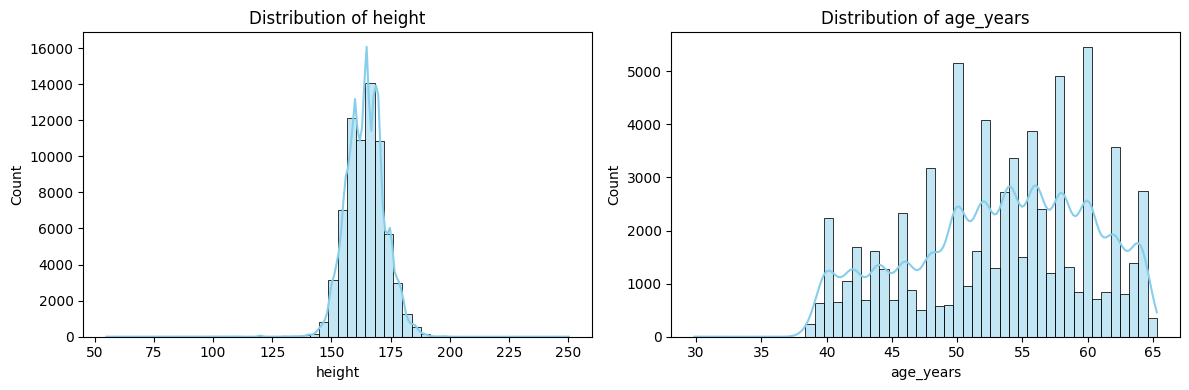

<function utils.plotting.plot_hist(df: pandas.core.frame.DataFrame, columns: list[str], bins=50, color='skyblue', jitter=False, edgecolor='black')>

In [28]:
plot_hist(df,["height","age_years"],bins = 50,color = "skyblue",jitter = True)
plot_hist

In [29]:
df[df["height"]<140].sort_values(by = "bmi",ascending=False).head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
12770,19594,1,75,168.0,120,80,1,1,1,0,1,1,54,298.7
27384,15292,1,80,178.0,140,90,3,3,0,0,1,1,42,278.1
22723,23386,1,55,81.0,130,90,1,1,0,0,1,1,64,267.8
23913,19074,1,81,156.0,140,90,1,1,0,0,1,0,52,237.8
29157,19088,1,60,69.0,110,70,1,1,0,0,0,0,52,191.7


#### Blood pressure values (ap_hi/ap_lo) cut off

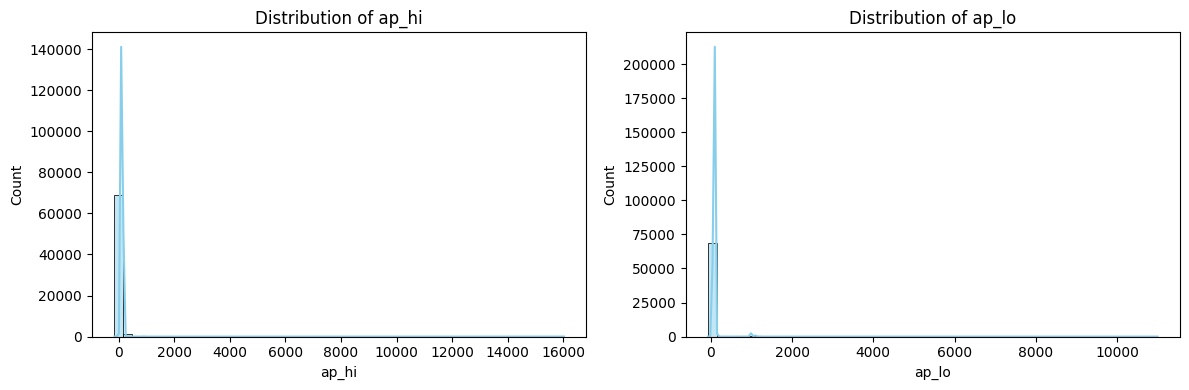

In [30]:
plot_hist(df,["ap_hi","ap_lo"])

## Dataset after cleaning

- Blood_pressure

In [31]:

# 1. Coerce to numeric
df[["ap_hi", "ap_lo"]] = df[["ap_hi", "ap_lo"]].apply(pd.to_numeric, errors="coerce")

# 2. Fix reversed values (if diastolic > systolic)
swap = df["ap_lo"] > df["ap_hi"]
df.loc[swap, ["ap_hi", "ap_lo"]] = df.loc[swap, ["ap_lo", "ap_hi"]].to_numpy()

# 3. Handle typos like 1000 → 100 (divide only if it makes sense)
mask_too_big = df["ap_lo"] >= 300
df.loc[mask_too_big, "ap_lo"] = df.loc[mask_too_big, "ap_lo"] / 10

mask_too_big_hi = df["ap_hi"] >= 300
df.loc[mask_too_big_hi, "ap_hi"] = df.loc[mask_too_big_hi, "ap_hi"] / 10

# 4. Keep only realistic values
ok = (
    df["ap_hi"].between(80, 250) &
    df["ap_lo"].between(40, 150) &
    (df["ap_hi"] >= df["ap_lo"] + 5)
)

# 5. Make sure values are not negative

df = df[(df["ap_hi"] > 0) & (df["ap_lo"] > 0)].copy()
df["ap_hi"] = df["ap_hi"].round().astype("Int64")
df["ap_lo"] = df["ap_lo"].round().astype("Int64")

df = df[ok].copy()

# Optional: pulse pressure (difference between hi and lo)
pulse_pressure = df["ap_hi"] - df["ap_lo"]
df = df[pulse_pressure.between(20, 100)]



/var/folders/zs/lhn3v0dx0v32gt7hm_r0m1zc0000gn/T/ipykernel_43054/1352090848.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 110.   100.    80.   100.   100.   103.3  100.   100.   110.   100.
  100.   110.   100.   100.1  100.   100.   100.   100.   100.   120.
  110.   110.   100.   100.   100.    90.2  100.    90.6  110.   110.
  110.   110.   100.   100.  1000.   100.   100.1  100.   100.   100.
  100.   100.   100.   100.   120.   100.   100.   804.4  104.4  100.
  100.   100.   100.   110.   100.   110.   100.   110.   100.   100.
  110.   110.   100.   100.   100.   110.   100.   100.    90.9  100.
  100.   100.   100.   100.   100.   100.   100.   100.   100.   110.
  100.   100.   100.   100.   100.   100.   100.   110.   100.   100.
  110.   100.   100.   100.   100.   110.   100.   910.   103.3  110.
  100.   100.   100.   110.   100.   100.   110.    90.2  120.   110.
  100.   100.   11

- Height + BMI


In [32]:
keep_height_bmi = pd.Series(True, index=df.index)
if "height" in df.columns:
    keep_height_bmi &= df["height"].between(140, 200)   
if "bmi" in df.columns:
    keep_height_bmi &= df["bmi"].between(12, 60)
df = df[keep_height_bmi].copy()

- Age

In [33]:
if "age_years" in df.columns:
    df = df[df["age_years"].between(18, 90)].copy()

#### Number of rows after cleaning

In [34]:
print(f"Rows before cleaning: {len(original_df)}")
print(f"Rows after filtering: {len(df)}")
print(f"Removed rows: {len(original_df) - len(df)}")

Rows before cleaning: 70000
Rows after filtering: 68420
Removed rows: 1580


In [35]:
df_clean = df.copy()

In [36]:
df_clean.shape

(68420, 14)

Notes / Justification (one-liners for your report)

Height 140–200 cm & BMI 12–60: adult-plausible bounds to remove unit/entry errors while keeping real extremes.

BP rules: physiology-first (ap_hi 80–250, ap_lo 40–150, systolic > diastolic, pulse pressure 20–100).

Age 18–90: keep adults; widen if your cohort expects older ages.

Recheck duplicates after cleaning: some rows turn identical once bad values are fixed.

In [37]:
df_clean.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,22.0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.9
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.5
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.7
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.0


## Plots

#### Gender

In [38]:
df_clean["gender_label"] = df["gender"].replace({1: "Male", 2: "Female"})

In [39]:
gender_counts = df_clean["gender_label"].value_counts().rename_axis("gender_label").reset_index(name="count")
gender_counts

,gender_label,count
0,Male,44547
1,Female,23873


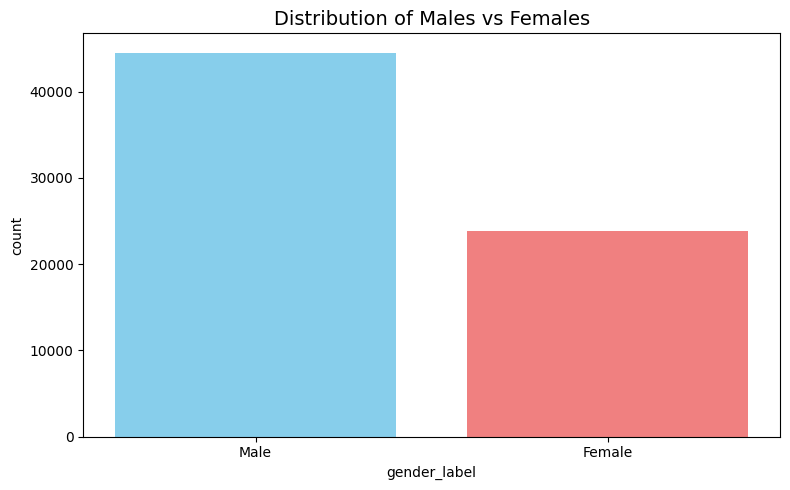

In [40]:
plot_bar(gender_counts,"gender_label","count",title ="Distribution of Males vs Females", color =["skyblue","lightcoral"])

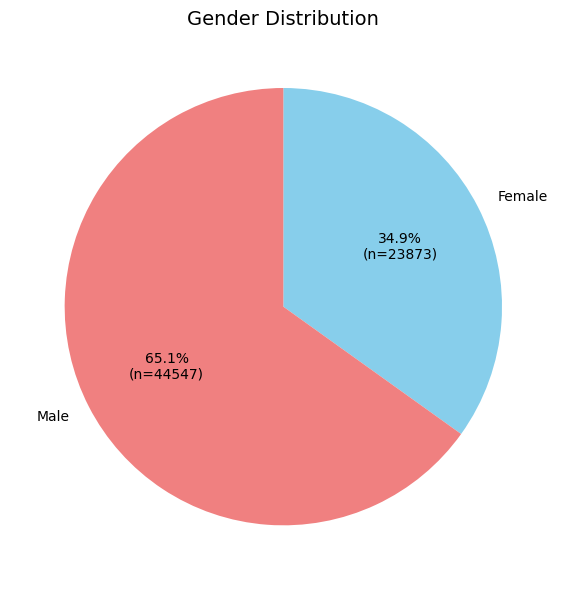

In [41]:
plot_pie(df_clean,"gender_label",title = "Gender Distribution",colors =["skyblue","lightcoral"])

In [42]:
# WHO-style bins
bins = [-np.inf, 18.5, 25, 30, 35, 40, np.inf]
labels = ["Underweight", "Normal", "Overweight",
          "Obesity I", "Obesity II", "Obesity III"]

df_clean["bmi_bin"] = pd.cut(
    df_clean["bmi"],
    bins=bins,
    labels=labels,
    right=False,           # intervals like [18.5, 25)
    include_lowest=True
).astype("category").cat.set_categories(labels, ordered=True)


### BMI category

In [43]:
df_clean.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,gender_label,bmi_bin
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,22.0,Female,Normal
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.9,Male,Obesity I
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.5,Male,Normal
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.7,Female,Overweight
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.0,Male,Normal


In [44]:
bmi_counts = (
    df_clean["bmi_bin"]
    .value_counts()                     # count how many in each category
    .rename_axis("bmi_bin")             # name the index column
    .reset_index(name="count")          # convert to DataFrame with 2 columns
    .sort_values("bmi_bin")             # optional: order categories
)

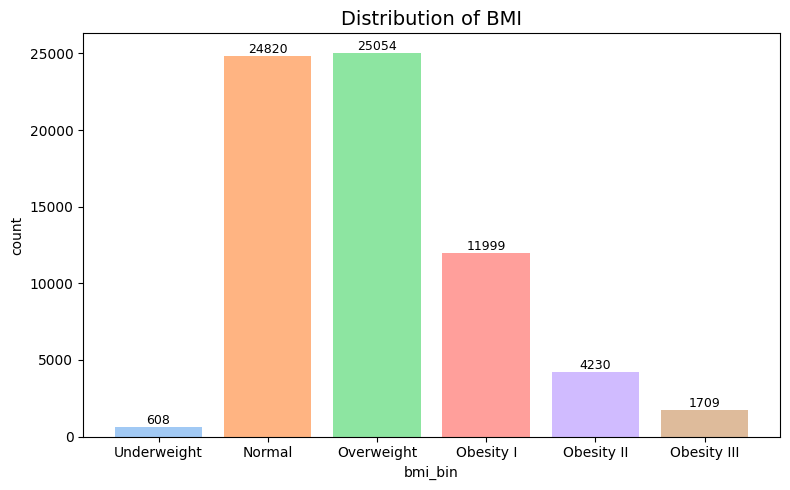

In [45]:
plot_bar2(bmi_counts,"bmi_bin","count",title ="Distribution of BMI", palette="pastel")

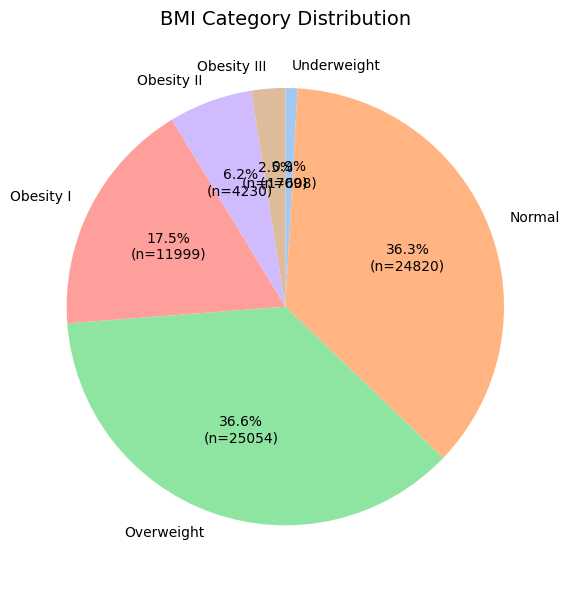

In [46]:
plot_pie(df_clean,"bmi_bin",title = "BMI Category Distribution",palette = "pastel")

### Blood pressure category

In [47]:
df_clean["bp_category"]=df_clean.apply(categorize_bp,axis=1)
df_clean["bp_category"].unique()

array(['Hypertension Stage 1', 'Hypertension Stage 2', 'Normal',
       'Elevated', 'Hypertensive Crisis'], dtype=object)

In [48]:
bp_order = [
    "Normal",
    "Elevated",
    "Hypertension Stage 1",
    "Hypertension Stage 2",
    "Hypertensive Crisis"
]

In [49]:
bp_colors = [
    "#4CAF50",  # Normal - green
    "#FFC107",  # Elevated - yellow
    "#FF9800",  # Stage 1 - orange
    "#F44336",  # Stage 2 - red
    "#9C27B0"   # Crisis - purple
]


In [50]:
bp_counts = (
    df_clean["bp_category"]
    .value_counts()
    .reindex(bp_order)    # ✅ reorder using your predefined order
    .dropna()             # remove any missing categories
)

In [57]:
bp_counts2 = (
    df_clean["bp_category"]
    .value_counts()
    .rename_axis("bp_category")
    .reset_index(name="count")
)

bp_counts2["bp_category"] = pd.Categorical(bp_counts2["bp_category"], categories=bp_order, ordered=True)
bp_counts2 = bp_counts2.sort_values("bp_category")

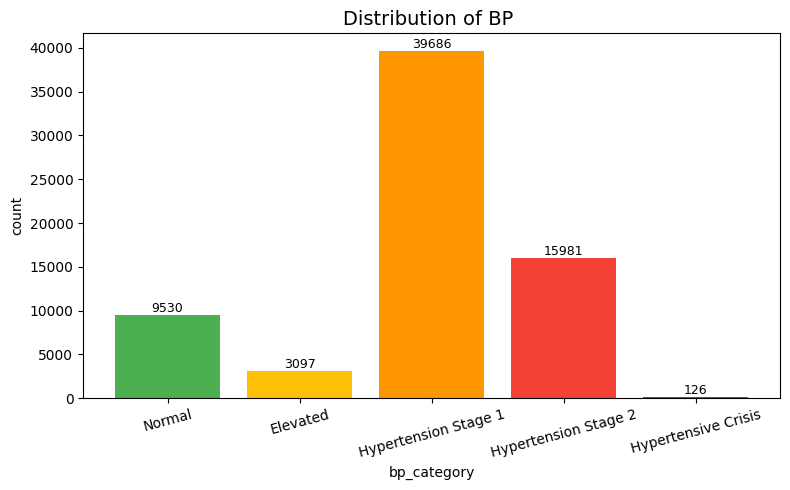

In [58]:
plot_bar2(bp_counts2,"bp_category","count",title ="Distribution of BP ", color = bp_colors,rotation = 15)

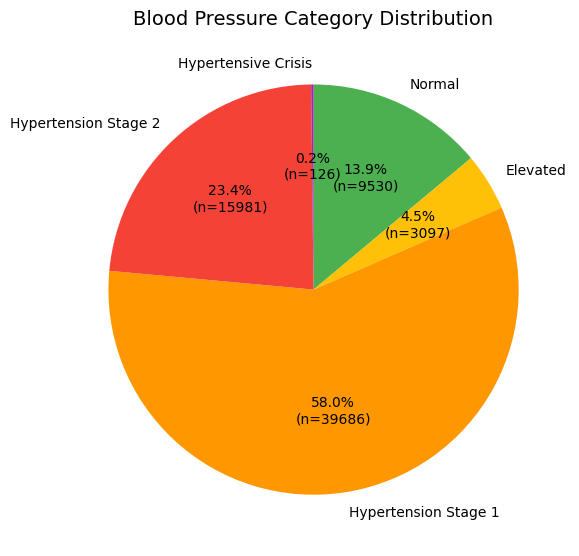

In [53]:
# Just reindex inside the plotting call:
df_temp = df_clean.copy()
df_temp["bp_category"] = pd.Categorical(df_temp["bp_category"], categories=bp_order, ordered=True)

plot_pie(df_temp, "bp_category", title="Blood Pressure Category Distribution", colors=bp_colors)

